In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data("/hpc/group/carin/fk43/FanjieKong/Megapixels/new_tfquantum/quantum/TensorNetwork/mnist.npz")

In [2]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape((60000, 28, 28, 1)).astype(np.float32)
y_train = to_categorical(y_train, 10).astype(np.float32)
x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test, 10)

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
# print(y_train)

In [3]:
xxx_train = (x_train-128)/255
xxx_test = (x_test-128)/255

In [4]:
xx_train = (tf.image.resize(x_train, [16,16]).numpy()-128)/255
xx_test = (tf.image.resize(x_test, [16,16]).numpy()-128)/255

In [5]:
class TNLayer(tf.keras.layers.Layer):
    
    def __init__(self, dim):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(dim, dim)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (self.dim, self.dim))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0]
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))

In [11]:
class Grid4DMERA(tf.keras.layers.Layer):
    
    def __init__(self, kernel_dims, bond_dims, output_dims):
        super(Grid4DMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        in_dims = int((kernel_dims//4)**2)
        self.entanglers = []
        self.isometries= []
        self.kernel_dims = kernel_dims
        self.output_dims = output_dims
        #entanglers
        self.entanglers1 = tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        self.entanglers2 = tf.Variable(tf.random.normal
                                             (shape=(bond_dims, bond_dims, 
                                                     bond_dims, bond_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True), 
                           tf.Variable(tf.random.normal(shape=(in_dims, in_dims, bond_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(in_dims, bond_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(bond_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers1, entanglers2, isometries1, isometries2, bias_var, kernel_dims):
            input_vv = []
            step = int(kernel_dims//4)
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*step:i*step+step, ii*step:ii*step+step, 0], (1, step**2)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, step**2))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
            e_nodes1 = tn.Node(entanglers1)
            e_nodes2 = tn.Node(entanglers2)
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
            
            e_nodes1[0] ^ input_nodes[5][0]
            e_nodes1[1] ^ input_nodes[6][0]
            e_nodes1[2] ^ input_nodes[9][0]
            e_nodes1[3] ^ input_nodes[10][0]

            e_nodes1[4] ^ isometries_nodes1[0][3]
            e_nodes1[5] ^ isometries_nodes1[1][2]
            e_nodes1[6] ^ isometries_nodes1[2][1]
            e_nodes1[7] ^ isometries_nodes1[3][0]     
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            
            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ e_nodes2[0]
            isometries_nodes1[1][4] ^ e_nodes2[1]
            isometries_nodes1[2][4] ^ e_nodes2[2]
            isometries_nodes1[3][4] ^ e_nodes2[3]

            e_nodes2[4] ^ isometries_nodes2[0]
            e_nodes2[5] ^ isometries_nodes2[1]
            e_nodes2[6] ^ isometries_nodes2[2]
            e_nodes2[7] ^ isometries_nodes2[3]

                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers1, self.entanglers2,
                                                 self.isometries1,  self.isometries2, self.bias, self.kernel_dims), inputs)
        return tf.reshape(output, (-1, self.output_dims))

In [23]:
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

model = tf.keras.Sequential()
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(28,28,1)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv2'))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv3'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(Dense(1936, activation='relu', name='fc1'))
model.add(Dense(10, activation='softmax', name='fc2'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 4)         40        
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 4)         148       
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 4)         148       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 4)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 484)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 1936)              938960    
_________________________________________________________________
fc2 (Dense)                  (None, 10)              

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tn_model = tf.keras.Sequential()
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(28,28,1)))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(tf.keras.layers.Flatten())
tn_model.add(TNLayer(22))
tn_model.add(Dense(10, activation='softmax', name='fc2'))
tn_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 4)         40        
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 4)         148       
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 4)         148       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 11, 11, 4)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 484)               0         
_________________________________________________________________
tn_layer_4 (TNLayer)         (None, 484)               2420      
_________________________________________________________________
fc2 (Dense)                  (None, 10)              

In [37]:
Dense = tf.keras.layers.Dense

MERA_model = tf.keras.Sequential()
MERA_model.add(tf.keras.Input(shape=(16,16,1)))
MERA_model.add(Grid4DMERA(input_dim=8, bond_dims=2, output_dims=10, n_layers=2))
#MERA_model.add(Dense(10, activation='softmax', name='fc'))
MERA_model.add(tf.keras.layers.Softmax())
#MERA_model.build(input_shape=(None, 8, 8, 1))
MERA_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grid4dmera_5 (Grid4DMERA)    (None, 10)                1114538   
_________________________________________________________________
softmax_5 (Softmax)          (None, 10)                0         
Total params: 1,114,538
Trainable params: 1,114,538
Non-trainable params: 0
_________________________________________________________________


In [26]:
%%time

# Traditional model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
hist = model.fit(x_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 46s 773us/sample - loss: 0.4282 - accuracy: 0.9378
Epoch 2/50
60000/60000 [==============================] - 46s 770us/sample - loss: 0.0746 - accuracy: 0.9768
Epoch 3/50
60000/60000 [==============================] - 45s 753us/sample - loss: 0.0583 - accuracy: 0.9815
Epoch 4/50
60000/60000 [==============================] - 44s 740us/sample - loss: 0.0479 - accuracy: 0.9849
Epoch 5/50
60000/60000 [==============================] - 45s 747us/sample - loss: 0.0366 - accuracy: 0.9890
Epoch 6/50
60000/60000 [==============================] - 44s 726us/sample - loss: 0.0342 - accuracy: 0.9896
Epoch 7/50
60000/60000 [==============================] - 41s 691us/sample - loss: 0.0260 - accuracy: 0.9917
Epoch 8/50
60000/60000 [==============================] - 41s 682us/sample - loss: 0.0239 - accuracy: 0.9929
Epoch 9/50
60000/60000 [==============================] - 41s 689us/sample - loss: 0.0207 - accuracy: 0.9

In [30]:
%%time

# TensorNetwork model
tn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
tn_hist = tn_model.fit(x_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 26s 433us/sample - loss: 0.0172 - accuracy: 0.9943
Epoch 2/50
60000/60000 [==============================] - 25s 419us/sample - loss: 0.0161 - accuracy: 0.9944
Epoch 3/50
60000/60000 [==============================] - 25s 422us/sample - loss: 0.0162 - accuracy: 0.9948
Epoch 4/50
60000/60000 [==============================] - 26s 426us/sample - loss: 0.0166 - accuracy: 0.9949
Epoch 5/50
60000/60000 [==============================] - 25s 420us/sample - loss: 0.0162 - accuracy: 0.9949
Epoch 6/50
60000/60000 [==============================] - 25s 419us/sample - loss: 0.0158 - accuracy: 0.9948
Epoch 7/50
60000/60000 [==============================] - 25s 421us/sample - loss: 0.0138 - accuracy: 0.9953
Epoch 8/50
60000/60000 [==============================] - 25s 419us/sample - loss: 0.0166 - accuracy: 0.9948
Epoch 9/50
60000/60000 [==============================] - 25s 420us/sample - loss: 0.0143 - accuracy: 0.9

In [66]:
%%time

# TensorNetwork model
MERA_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
MERA_hist = MERA_model.fit(xx_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 33s 546us/sample - loss: 158068766297834.5625 - accuracy: 0.6436
Epoch 2/50
60000/60000 [==============================] - 31s 521us/sample - loss: 179292850784881.8750 - accuracy: 0.6355
Epoch 3/50
60000/60000 [==============================] - 31s 516us/sample - loss: 190894404509525.5938 - accuracy: 0.6460
Epoch 4/50
60000/60000 [==============================] - 31s 514us/sample - loss: 199557121822005.6562 - accuracy: 0.6534
Epoch 5/50
60000/60000 [==============================] - 31s 519us/sample - loss: 196129618943331.5625 - accuracy: 0.6677
Epoch 6/50
60000/60000 [==============================] - 31s 511us/sample - loss: 191997164233162.7500 - accuracy: 0.6808
Epoch 7/50
60000/60000 [==============================] - 31s 515us/sample - loss: 191954278925712.3125 - accuracy: 0.6890
Epoch 8/50
60000/60000 [==============================] - 31s 517us/sample - loss: 206252057207277.7188 - accuracy: 

In [68]:
MERA_hist2 = MERA_model.fit(xx_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 31s 522us/sample - loss: 186773302437688.1250 - accuracy: 0.8538
Epoch 2/50
60000/60000 [==============================] - 32s 541us/sample - loss: 191473694205559.8750 - accuracy: 0.8563
Epoch 3/50
60000/60000 [==============================] - 32s 530us/sample - loss: 184983792920821.7500 - accuracy: 0.8567
Epoch 4/50
60000/60000 [==============================] - 33s 546us/sample - loss: 219898065157182.8125 - accuracy: 0.8489
Epoch 5/50
60000/60000 [==============================] - 33s 551us/sample - loss: 169513678458060.7812 - accuracy: 0.8641
Epoch 6/50
60000/60000 [==============================] - 33s 543us/sample - loss: 211824610221909.5938 - accuracy: 0.8551
Epoch 7/50
60000/60000 [==============================] - 32s 532us/sample - loss: 199381090948804.3438 - accuracy: 0.8611
Epoch 8/50
60000/60000 [==============================] - 30s 507us/sample - loss: 178153722347380.1875 - accuracy: 

In [56]:
Dense = tf.keras.layers.Dense

MERA_model = tf.keras.Sequential()
MERA_model.add(tf.keras.Input(shape=(16,16,1)))
MERA_model.add(Grid4DMERA(input_dim=8, bond_dims=2, output_dims=10, n_layers=2))
#MERA_model.add(Dense(10, activation='softmax', name='fc'))
MERA_model.add(tf.keras.layers.Softmax())
#MERA_model.build(input_shape=(None, 8, 8, 1))
MERA_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grid4dmera_11 (Grid4DMERA)   (None, 10)                1114538   
_________________________________________________________________
softmax_11 (Softmax)         (None, 10)                0         
Total params: 1,114,538
Trainable params: 1,114,538
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.evaluate(x=x_test, y=y_test)

10000/10000 [==============================] - 3s 273us/sample - loss: 0.2201 - accuracy: 0.9828


[0.2201170140072275, 0.9828]

In [33]:
tn_model.evaluate(x=x_test, y=y_test)

10000/10000 [==============================] - 2s 191us/sample - loss: 0.0815 - accuracy: 0.9852


[0.08147503402757175, 0.9852]

In [67]:
# TN model
MERA_model.evaluate(x=xx_test, y=y_test)

10000/10000 [==============================] - 4s 379us/sample - loss: 2013894160543016.5000 - accuracy: 0.5882


[2013894160543016.5, 0.5882]

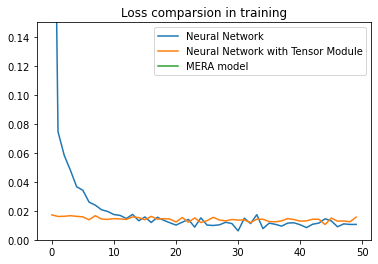

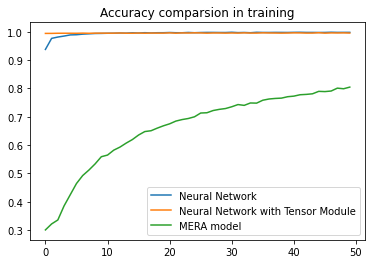

In [65]:
loss = hist.history['loss']
acc = hist.history['accuracy']
tn_loss = tn_hist.history['loss']
tn_acc = tn_hist.history['accuracy']
MERA_loss = MERA_hist.history['loss']
MERA_acc = MERA_hist.history['accuracy']

plt.plot(loss, label='Neural Network')
plt.plot(tn_loss, label='Neural Network with Tensor Module')
plt.plot(MERA_loss, label='MERA model')
plt.title('Loss comparsion in training')
plt.ylim(0, 0.15)
plt.legend()
plt.show()

plt.plot(acc, label='Neural Network')
plt.plot(tn_acc, label='Neural Network with Tensor Module')
plt.plot(MERA_acc, label='MERA model')
plt.title('Accuracy comparsion in training')
plt.legend()
plt.show()

In [31]:
MERA_curves = []
lr = [0.0005, 0.0001, 0.0005, 0.00001, 0.0000005]
for i in range(5):
    MERA_model = tf.keras.Sequential()
    MERA_model.add(tf.keras.Input(shape=(16,16,1)))
    MERA_model.add(Grid4DMERA(kernel_dims=16, bond_dims=2, output_dims=10))
    #MERA_model.add(Dense(10, activation='softmax', name='fc'))
    MERA_model.add(tf.keras.layers.Softmax())
    #MERA_model.build(input_shape=(None, 8, 8, 1))
    MERA_model.summary()

    #%%time

    # TensorNetwork model
    MERA_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr[i]), metrics=['accuracy'])
    MERA_curves.append(MERA_model.fit(xx_train, y_train, epochs=20, verbose=1))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grid4dmera_16 (Grid4DMERA)   (None, 10)                1114538   
_________________________________________________________________
softmax_16 (Softmax)         (None, 10)                0         
Total params: 1,114,538
Trainable params: 1,114,538
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 45s 751us/sample - loss: nan - accuracy: 0.1049
Epoch 2/20
60000/60000 [==============================] - 43s 724us/sample - loss: nan - accuracy: 0.0987
Epoch 3/20
60000/60000 [==============================] - 43s 715us/sample - loss: nan - accuracy: 0.0987
Epoch 4/20
60000/60000 [==============================] - 43s 716us/sample - loss: nan - accuracy: 0.0987
Epoch 5/20
60000/60000 [==============================] - 

In [32]:
# TN model
MERA_model.evaluate(x=xx_test, y=y_test)

10000/10000 [==============================] - 4s 361us/sample - loss: 230661233921.2288 - accuracy: 0.6043


[230661233921.2288, 0.6043]

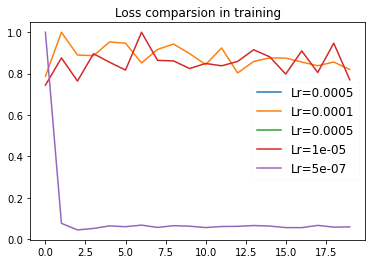

In [79]:
for idx, e_h in enumerate(MERA_curves):

    tn_loss = np.array(e_h.history['loss'])

    plt.plot(tn_loss/tn_loss.max(), label='Lr=' + str(lr[idx]))
    plt.title('Loss comparsion in training')

plt.legend(prop={'size': 12}, framealpha=0.1)
plt.show()

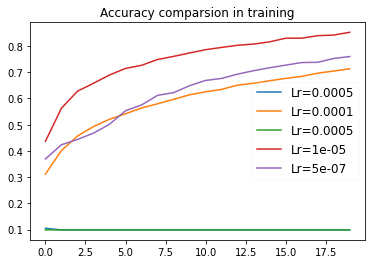

In [78]:
for idx, e_h in enumerate(MERA_curves):

    tn_loss = np.array(e_h.history['accuracy'])

    plt.plot(tn_loss, label='Lr=' + str(lr[idx]))
    plt.title('Accuracy comparsion in training')

plt.legend(prop={'size': 12}, framealpha=0.1)
plt.show()

In [54]:
class Grid4DMERA(tf.keras.layers.Layer):
    
    def __init__(self, kernel_dims, bond_dims, output_dims, std_init):
        super(Grid4DMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        in_dims = int((kernel_dims//4)**2)
        self.entanglers = []
        self.isometries= []
        self.kernel_dims = kernel_dims
        self.output_dims = output_dims
        #entanglers
        self.entanglers1 = tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/std_init), 
                                              trainable=True)
        self.entanglers2 = tf.Variable(tf.random.normal
                                             (shape=(bond_dims, bond_dims, 
                                                     bond_dims, bond_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/std_init), 
                                              trainable=True)
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/10*std_init),
                                            trainable=True), 
                           tf.Variable(tf.random.normal(shape=(in_dims, in_dims, bond_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*std_init),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(in_dims, bond_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*std_init),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(bond_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*std_init),
                                            trainable=True)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/10*std_init),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers1, entanglers2, isometries1, isometries2, bias_var, kernel_dims):
            input_vv = []
            step = int(kernel_dims//4)
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*step:i*step+step, ii*step:ii*step+step, 0], (1, step**2)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, step**2))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
            e_nodes1 = tn.Node(entanglers1)
            e_nodes2 = tn.Node(entanglers2)
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
            
            e_nodes1[0] ^ input_nodes[5][0]
            e_nodes1[1] ^ input_nodes[6][0]
            e_nodes1[2] ^ input_nodes[9][0]
            e_nodes1[3] ^ input_nodes[10][0]

            e_nodes1[4] ^ isometries_nodes1[0][3]
            e_nodes1[5] ^ isometries_nodes1[1][2]
            e_nodes1[6] ^ isometries_nodes1[2][1]
            e_nodes1[7] ^ isometries_nodes1[3][0]     
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            
            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ e_nodes2[0]
            isometries_nodes1[1][4] ^ e_nodes2[1]
            isometries_nodes1[2][4] ^ e_nodes2[2]
            isometries_nodes1[3][4] ^ e_nodes2[3]

            e_nodes2[4] ^ isometries_nodes2[0]
            e_nodes2[5] ^ isometries_nodes2[1]
            e_nodes2[6] ^ isometries_nodes2[2]
            e_nodes2[7] ^ isometries_nodes2[3]

                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers1, self.entanglers2,
                                                 self.isometries1,  self.isometries2, self.bias, self.kernel_dims), inputs)
        return tf.reshape(output, (-1, self.output_dims))

In [56]:
MERA_curves2 = []
std_init = [10000, 5000, 10000, 50000, 100000]
for i in range(5):
    MERA_model2 = tf.keras.Sequential()
    MERA_model2.add(tf.keras.Input(shape=(16,16,1)))
    MERA_model2.add(Grid4DMERA(kernel_dims=16, bond_dims=2, output_dims=10, std_init=std_init[i]))
    #MERA_model.add(Dense(10, activation='softmax', name='fc'))
    MERA_model2.add(tf.keras.layers.Softmax())
    #MERA_model.build(input_shape=(None, 8, 8, 1))
    MERA_model2.summary()

    #%%time

    # TensorNetwork model
    MERA_model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
    MERA_curves2.append(MERA_model2.fit(xx_train, y_train, epochs=20, verbose=1))

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grid4dmera_35 (Grid4DMERA)   (None, 10)                1114538   
_________________________________________________________________
softmax_35 (Softmax)         (None, 10)                0         
Total params: 1,114,538
Trainable params: 1,114,538
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 37s 611us/sample - loss: 1296980575041548.0000 - accuracy: 0.3411
Epoch 2/20
60000/60000 [==============================] - 34s 572us/sample - loss: 1544176133595568.5000 - accuracy: 0.4607
Epoch 3/20
60000/60000 [==============================] - 41s 680us/sample - loss: 1341857554214560.2500 - accuracy: 0.5206
Epoch 4/20
60000/60000 [==============================] - 37s 609us/sample - loss: 1436510629558939.2500 - acc

In [57]:
# TN model
MERA_model2.evaluate(x=xx_test, y=y_test)

10000/10000 [==============================] - 4s 395us/sample - loss: nan - accuracy: 0.0980


[nan, 0.098]

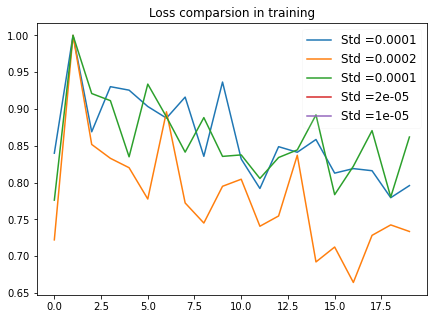

<Figure size 576x576 with 0 Axes>

In [85]:
plt.figure(figsize=(7, 5))
for idx, e_h in enumerate(MERA_curves2):

    tn_loss = np.array(e_h.history['loss'])

    plt.plot(tn_loss/tn_loss.max(), label='Std =' + str(1/std_init[idx]))
    plt.title('Loss comparsion in training')

plt.legend(prop={'size': 12}, framealpha=0.1)
plt.figure(figsize=(8, 8))
plt.show()

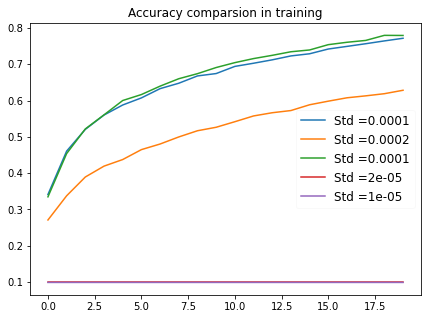

In [86]:
plt.figure(figsize=(7, 5))
for idx, e_h in enumerate(MERA_curves2):

    tn_loss = np.array(e_h.history['accuracy'])

    plt.plot(tn_loss, label='Std =' + str(1/std_init[idx]))
    plt.title('Accuracy comparsion in training')

plt.legend(prop={'size': 12}, framealpha=0.1)
plt.show()